<a href="https://colab.research.google.com/github/yuxuan0702/Hospital_Death_Analysis-/blob/master/cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency

plt.style.use('ggplot')
%matplotlib inline

In [0]:
#import data
df=pd.read_csv('/content/drive/My Drive/widsdatathon2020/training_v2.csv')
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,...,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0.0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,37.0,37.0,51.0,7.45,...,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0.0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0.0,68.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0.0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1.0,60.0,30.0,30.0,142.0,7.39,...,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0.04,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0.0,103.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [0]:
# check if there is missing 
def check_missing_data(df):
    # check for any missing data in the df (display in descending order)
    return df.isnull().sum().sort_values(ascending=False)

In [0]:
check_missing_data(df)

h1_bilirubin_min    84619
h1_bilirubin_max    84619
h1_lactate_max      84369
h1_lactate_min      84369
h1_albumin_min      83824
                    ...  
icu_id                  0
icu_stay_type           0
icu_type                0
pre_icu_los_days        0
encounter_id            0
Length: 186, dtype: int64

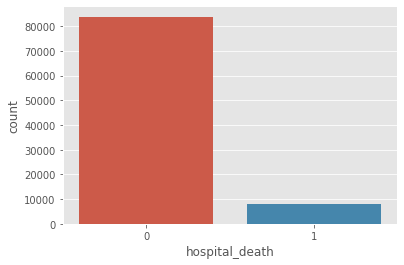

In [0]:
#check the distribution of the target
sns.countplot(data=df,x='hospital_death')

#Training set preparation 

## Drop columns with 50% missing values 

In [0]:
#choose columns with over 50% values and drop na 
mask=df.isna().sum()/len(df)<0.5
reduced_df=df.loc[:,mask]
reduced_df.dropna(axis=0,how='any',inplace=True)
reduced_df.set_index('encounter_id',drop=True,inplace=True)
reduced_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,...,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,113.0,502.01,0,0.0,31.0,2.51,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,36.0,134.0,39.3,0.0,14.1,68.0,37.0,68.0,...,131.0,115.0,131.0,115.0,39.5,37.5,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,108.0,203.01,0,0.0,9.0,0.56,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,33.0,145.0,35.1,1.0,12.7,95.0,31.0,95.0,...,95.0,71.0,95.0,71.0,36.3,36.3,11.0,9.0,8.6,8.0,0.71,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
33181,74489,83,0,67.0,27.560000,0,Caucasian,M,190.5,Direct Admit,Accident & Emergency,95,admit,Med-Surg ICU,0.000694,0,100.0,301.0,403.01,0,0.0,13.0,0.71,4.0,6.0,0.0,5.0,156.0,113.0,44.2,0.0,130.0,35.0,137.0,36.6,0.0,10.9,100.0,61.0,100.0,...,143.0,143.0,143.0,143.0,36.7,36.7,13.0,13.0,8.8,8.8,0.71,0.71,156.0,125.0,27.0,27.0,15.6,15.6,44.2,44.2,159.0,159.0,3.9,3.7,137.0,137.0,10.9,10.9,0.05,0.02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
22471,112115,118,0,46.0,25.845717,0,Hispanic,M,167.6,Emergency Department,Accident & Emergency,92,admit,CTICU,0.000000,0,72.6,108.0,203.01,0,0.0,15.0,1.00,1.0,4.0,0.0,1.0,143.0,114.0,44.2,1.0,113.0,34.0,132.0,36.4,1.0,9.7,89.0,61.0,89.0,...,169.0,115.0,169.0,115.0,36.6,36.6,15.0,15.0,8.5,8.5,1.00,1.00,143.0,143.0,27.0,27.0,15.0,15.0,44.2,44.2,247.0,247.0,4.9,4.9,132.0,132.0,9.7,9.7,0.11,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
95460,120539,118,0,87.0,21.963763,0,Caucasian,M,180.3,Floor,Floor,97,admit,MICU,5.046528,0,71.4,113.0,501.05,0,0.0,13.0,0.94,3.0,6.0,0.0,1.0,105.0,99.0,28.9,0.0,133.0,33.0,146.0,36.3,1.0,9.9,88.0,65.0,88.0,...,159.0,129.0,159.0,129.0,36.8,36.3,13.0,13.0,7.7,7.7,0.94,0.94,144.0,87.0,26.0,26.0,9.7,9.7,28.9,28.9,273.0,273.0,3.4,3.3,146.0,146.0,9.9,9.9,0.31,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular


## Split data to categorical and numeric data 


In [0]:
#change columns to category type 
def cat_type(col_name):
  reduced_df[col_name]=reduced_df[col_name].astype('category')
  return reduced_df.dtypes

In [0]:
#select binary and string columns to convert to category 
col_name=['hospital_death','ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type','readmission_status','apache_post_operative','arf_apache','gcs_unable_apache','intubated_apache','ventilated_apache','aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis','apache_3j_bodysystem','apache_2_bodysystem','elective_surgery']
cat_type(col_name)

#catgory data
cat_cols=reduced_df[col_name]
cat_cols.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,hospital_death,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,readmission_status,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,elective_surgery
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,
66154,0,Caucasian,M,Floor,Floor,admit,CTICU,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
114252,0,Caucasian,F,Floor,Floor,admit,Med-Surg ICU,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
33181,0,Caucasian,M,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,0
22471,0,Hispanic,M,Emergency Department,Accident & Emergency,admit,CTICU,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
95460,0,Caucasian,M,Floor,Floor,admit,MICU,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0


## Numeric Data preparation

In [0]:
#choose all numeric columns 
num_cols = [i for i in reduced_df.columns if i not in col_name]
num_data=reduced_df.loc[:,num_cols]
num_data.head()

,patient_id,hospital_id,age,bmi,height,icu_id,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,temp_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,...,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
66154,25312,118,68.0,22.730000,180.3,92,0.541667,73.9,113.0,502.01,31.0,2.51,3.0,6.0,4.0,168.0,118.0,27.4,40.0,36.0,134.0,39.3,14.1,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,131.0,...,119.0,108.0,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,131.0,115.0,39.5,37.5,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,0.10,0.05
114252,59342,81,77.0,27.420000,160.0,90,0.927778,70.2,108.0,203.01,9.0,0.56,1.0,3.0,1.0,145.0,120.0,36.9,46.0,33.0,145.0,35.1,12.7,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,159.0,...,114.0,100.0,85.0,57.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,95.0,71.0,36.3,36.3,11.0,9.0,8.6,8.0,0.71,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,0.47,0.29
33181,74489,83,67.0,27.560000,190.5,95,0.000694,100.0,301.0,403.01,13.0,0.71,4.0,6.0,5.0,156.0,113.0,44.2,130.0,35.0,137.0,36.6,10.9,100.0,61.0,100.0,61.0,113.0,83.0,127.0,80.0,127.0,80.0,32.0,10.0,97.0,91.0,173.0,107.0,173.0,...,83.0,83.0,111.0,111.0,111.0,111.0,12.0,12.0,97.0,97.0,143.0,143.0,143.0,143.0,36.7,36.7,13.0,13.0,8.8,8.8,0.71,0.71,156.0,125.0,27.0,27.0,15.6,15.6,44.2,44.2,159.0,159.0,3.9,3.7,137.0,137.0,10.9,10.9,0.05,0.02
22471,112115,118,46.0,25.845717,167.6,92,0.000000,72.6,108.0,203.01,15.0,1.00,1.0,4.0,1.0,143.0,114.0,44.2,113.0,34.0,132.0,36.4,9.7,89.0,61.0,89.0,61.0,98.0,64.0,113.0,76.0,113.0,76.0,22.0,9.0,100.0,88.0,169.0,102.0,169.0,...,94.0,80.0,104.0,88.0,104.0,88.0,21.0,9.0,99.0,95.0,169.0,115.0,169.0,115.0,36.6,36.6,15.0,15.0,8.5,8.5,1.00,1.00,143.0,143.0,27.0,27.0,15.0,15.0,44.2,44.2,247.0,247.0,4.9,4.9,132.0,132.0,9.7,9.7,0.11,0.06
95460,120539,118,87.0,21.963763,180.3,97,5.046528,71.4,113.0,501.05,13.0,0.94,3.0,6.0,1.0,105.0,99.0,28.9,133.0,33.0,146.0,36.3,9.9,88.0,65.0,88.0,65.0,116.0,74.0,123.0,90.0,123.0,90.0,36.0,16.0,100.0,90.0,179.0,129.0,179.0,...,116.0,92.0,102.0,90.0,102.0,90.0,36.0,28.0,99.0,90.0,159.0,129.0,159.0,129.0,36.8,36.3,13.0,13.0,7.7,7.7,0.94,0.94,144.0,87.0,26.0,26.0,9.7,9.7,28.9,28.9,273.0,273.0,3.4,3.3,146.0,146.0,9.9,9.9,0.31,0.14


drop some features without specific informations 

In [0]:
#dropidcol
id=['hospital_id','hospital_id','icu_id']
num_data.drop(columns=id,inplace=True)
num_data.head()

,patient_id,age,bmi,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,temp_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,...,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
66154,25312,68.0,22.730000,180.3,0.541667,73.9,113.0,502.01,31.0,2.51,3.0,6.0,4.0,168.0,118.0,27.4,40.0,36.0,134.0,39.3,14.1,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,131.0,73.0,39.9,...,119.0,108.0,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,131.0,115.0,39.5,37.5,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,0.10,0.05
114252,59342,77.0,27.420000,160.0,0.927778,70.2,108.0,203.01,9.0,0.56,1.0,3.0,1.0,145.0,120.0,36.9,46.0,33.0,145.0,35.1,12.7,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,159.0,67.0,36.3,...,114.0,100.0,85.0,57.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,95.0,71.0,36.3,36.3,11.0,9.0,8.6,8.0,0.71,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,0.47,0.29
33181,74489,67.0,27.560000,190.5,0.000694,100.0,301.0,403.01,13.0,0.71,4.0,6.0,5.0,156.0,113.0,44.2,130.0,35.0,137.0,36.6,10.9,100.0,61.0,100.0,61.0,113.0,83.0,127.0,80.0,127.0,80.0,32.0,10.0,97.0,91.0,173.0,107.0,173.0,107.0,36.8,...,83.0,83.0,111.0,111.0,111.0,111.0,12.0,12.0,97.0,97.0,143.0,143.0,143.0,143.0,36.7,36.7,13.0,13.0,8.8,8.8,0.71,0.71,156.0,125.0,27.0,27.0,15.6,15.6,44.2,44.2,159.0,159.0,3.9,3.7,137.0,137.0,10.9,10.9,0.05,0.02
22471,112115,46.0,25.845717,167.6,0.000000,72.6,108.0,203.01,15.0,1.00,1.0,4.0,1.0,143.0,114.0,44.2,113.0,34.0,132.0,36.4,9.7,89.0,61.0,89.0,61.0,98.0,64.0,113.0,76.0,113.0,76.0,22.0,9.0,100.0,88.0,169.0,102.0,169.0,102.0,37.1,...,94.0,80.0,104.0,88.0,104.0,88.0,21.0,9.0,99.0,95.0,169.0,115.0,169.0,115.0,36.6,36.6,15.0,15.0,8.5,8.5,1.00,1.00,143.0,143.0,27.0,27.0,15.0,15.0,44.2,44.2,247.0,247.0,4.9,4.9,132.0,132.0,9.7,9.7,0.11,0.06
95460,120539,87.0,21.963763,180.3,5.046528,71.4,113.0,501.05,13.0,0.94,3.0,6.0,1.0,105.0,99.0,28.9,133.0,33.0,146.0,36.3,9.9,88.0,65.0,88.0,65.0,116.0,74.0,123.0,90.0,123.0,90.0,36.0,16.0,100.0,90.0,179.0,129.0,179.0,129.0,36.8,...,116.0,92.0,102.0,90.0,102.0,90.0,36.0,28.0,99.0,90.0,159.0,129.0,159.0,129.0,36.8,36.3,13.0,13.0,7.7,7.7,0.94,0.94,144.0,87.0,26.0,26.0,9.7,9.7,28.9,28.9,273.0,273.0,3.4,3.3,146.0,146.0,9.9,9.9,0.31,0.14


### drop columns with variance less than 1 

In [0]:
#select those with variance over 1 
sel=VarianceThreshold(threshold=1)
sel.fit(num_data)

#choose data which variance over 1
threshold=sel.get_support()
num_data.columns[threshold]
meaningful_num=num_data.loc[:,threshold]

#look at meaningful numbers 
meaningful_num.head()

,patient_id,age,bmi,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,d1_bun_max,d1_bun_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
66154,25312,68.0,22.730000,180.3,0.541667,73.9,113.0,502.01,31.0,2.51,6.0,4.0,168.0,118.0,27.4,40.0,36.0,134.0,14.1,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,131.0,73.0,68.0,63.0,68.0,63.0,119.0,108.0,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,131.0,115.0,31.0,30.0,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,233.0,233.0,136.0,134.0,14.1,14.1
114252,59342,77.0,27.420000,160.0,0.927778,70.2,108.0,203.01,9.0,0.56,3.0,1.0,145.0,120.0,36.9,46.0,33.0,145.0,12.7,95.0,31.0,95.0,31.0,118.0,72.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,159.0,67.0,61.0,48.0,61.0,48.0,114.0,100.0,85.0,57.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,95.0,71.0,11.0,9.0,0.71,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,557.0,487.0,145.0,145.0,23.3,12.7
33181,74489,67.0,27.560000,190.5,0.000694,100.0,301.0,403.01,13.0,0.71,6.0,5.0,156.0,113.0,44.2,130.0,35.0,137.0,10.9,100.0,61.0,100.0,61.0,113.0,83.0,127.0,80.0,127.0,80.0,32.0,10.0,97.0,91.0,173.0,107.0,173.0,107.0,89.0,89.0,89.0,89.0,83.0,83.0,111.0,111.0,111.0,111.0,12.0,12.0,97.0,97.0,143.0,143.0,143.0,143.0,13.0,13.0,0.71,0.71,156.0,125.0,27.0,27.0,15.6,15.6,44.2,44.2,159.0,159.0,137.0,137.0,10.9,10.9
22471,112115,46.0,25.845717,167.6,0.000000,72.6,108.0,203.01,15.0,1.00,4.0,1.0,143.0,114.0,44.2,113.0,34.0,132.0,9.7,89.0,61.0,89.0,61.0,98.0,64.0,113.0,76.0,113.0,76.0,22.0,9.0,100.0,88.0,169.0,102.0,169.0,102.0,89.0,63.0,89.0,63.0,94.0,80.0,104.0,88.0,104.0,88.0,21.0,9.0,99.0,95.0,169.0,115.0,169.0,115.0,15.0,15.0,1.00,1.00,143.0,143.0,27.0,27.0,15.0,15.0,44.2,44.2,247.0,247.0,132.0,132.0,9.7,9.7
95460,120539,87.0,21.963763,180.3,5.046528,71.4,113.0,501.05,13.0,0.94,6.0,1.0,105.0,99.0,28.9,133.0,33.0,146.0,9.9,88.0,65.0,88.0,65.0,116.0,74.0,123.0,90.0,123.0,90.0,36.0,16.0,100.0,90.0,179.0,129.0,179.0,129.0,71.0,65.0,71.0,65.0,116.0,92.0,102.0,90.0,102.0,90.0,36.0,28.0,99.0,90.0,159.0,129.0,159.0,129.0,13.0,13.0,0.94,0.94,144.0,87.0,26.0,26.0,9.7,9.7,28.9,28.9,273.0,273.0,146.0,146.0,9.9,9.9


### PCA
- Dimension Reduction 
- Avoid correlated variables 

#### Standardize the data 

In [0]:
# transform data 
ss=StandardScaler()
ss.fit(meaningful_num)
transform_data=pd.DataFrame(data=ss.transform(meaningful_num),index=meaningful_num.index,columns=meaningful_num.columns)
transform_data.head()

,patient_id,age,bmi,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,d1_bun_max,d1_bun_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
66154,-1.067857,0.323313,-0.790452,0.964550,-0.099764,-0.423560,-0.833813,-0.174051,0.266316,0.666565,0.430837,0.051416,0.112902,0.544401,-0.854216,-1.090425,0.768546,-0.784882,0.289079,-1.181023,-0.894139,-1.181286,-0.894497,0.617989,0.129212,-0.818636,-1.130100,-0.820456,-1.131110,0.438756,-0.496830,0.416221,-1.628598,-0.778356,-1.089884,-0.776829,-1.089724,-0.455165,0.080216,-0.454216,0.076395,1.146193,1.179437,-0.257996,0.399498,-0.254454,0.400837,0.448438,0.220678,0.667466,-3.276021,-0.098954,0.027213,-0.093783,0.027845,0.260640,0.343470,0.648570,0.636941,-0.076659,-0.125650,-1.231372,-1.632556,-1.211333,-0.868992,-1.175311,-0.832967,0.277648,0.407857,-0.687554,-0.775251,0.228173,0.464274
114252,-0.165814,0.868802,-0.219481,-0.932483,0.067446,-0.571766,-0.892604,-0.810815,-0.798898,-0.587764,-1.805133,-1.827344,-0.146187,0.609141,0.540746,-0.952077,0.564409,1.350185,0.086600,0.209474,-1.377976,0.209570,-1.378263,0.572179,0.129212,0.693448,-1.691391,0.696609,-1.694267,0.247034,-0.052691,0.416221,-2.037750,0.338913,-1.404518,0.339855,-1.404402,-0.834140,-0.858565,-0.833027,-0.860891,0.919088,0.785955,-0.306871,-1.119850,-0.303429,-1.119561,1.134182,2.011291,-1.211772,-3.900115,-1.403809,-1.656770,-1.399978,-1.656715,-0.705981,-0.773026,-0.509986,-0.595506,-0.345235,0.387360,0.625027,0.601256,-0.102145,0.063324,0.355804,0.442172,3.884500,3.289733,1.206102,1.480004,1.575981,0.229693
33181,0.235691,0.262704,-0.202437,1.917739,-0.334039,0.621895,1.376727,-0.384886,-0.605222,-0.491277,0.430837,0.677670,-0.022275,0.382552,1.612664,0.984792,0.700500,-0.202591,-0.173730,0.466973,1.041208,0.467137,1.040564,0.343130,0.792118,1.034887,1.255388,1.039172,1.262310,0.247034,-0.496830,-1.866208,0.110300,0.897548,0.693039,0.898197,0.693447,0.681759,1.707436,0.682215,1.701024,-0.488961,-0.050192,0.963874,1.810320,0.969908,1.812635,-1.471643,-0.853690,-0.460077,0.312518,0.335998,1.098838,0.341616,1.099837,-0.609319,-0.560360,-0.509986,-0.484807,-0.216785,0.306359,0.625027,0.804330,1.885151,1.970333,1.532345,1.629371,-0.546140,-0.431744,-0.477148,-0.160181,-0.240630,-0.071911
22471,1.233054,-1.010103,-0.411138,-0.222264,-0.334339,-0.475632,-0.892604,-0.810815,-0.508385,-0.304736,-1.059810,-1.827344,-0.168716,0.414922,1.612664,0.592807,0.632454,-1.173077,-0.347283,-0.099526,1.041208,-0.099509,1.040564,-0.344018,-0.352902,0.352010,0.974743,0.354046,0.980732,-0.711574,-0.718899,0.416221,-0.196565,0.737938,0.430844,0.738671,0.431216,0.681759,0.080216,0.682215,0.076395,0.010669,-0.197747,0.621750,0.562285,0.627087,0.563737,-0.237305,-1.390874,0.291618,0.000472,1.278394,0.027213,1.284979,0.027845,-0.512656,-0.454027,-0.323330,-0.270789,-0.368589,0.792368,0.625027,0.804330,1.607854,1.716065,1.532345,1.629371,0.433499,0.566701,-1.529180

#### Fit pca, choose the right principle numbers 

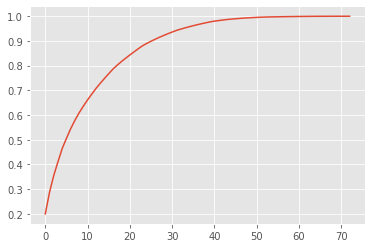

In [0]:
# fit PCA with the transform data 
pca=PCA()
pca.fit(transform_data)
ratio=pca.explained_variance_ratio_.cumsum()
plt.plot(ratio)

In [0]:
#pca summary
pcsSummary_df = pd.DataFrame({'Proportion of variance': pca.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pca.explained_variance_ratio_)}) 
pcsSummary_df

,Proportion of variance,Cumulative proportion
0,0.199704,0.199704
1,0.087493,0.287197
2,0.067925,0.355122
3,0.055892,0.411013
4,0.053410,0.464423
...,...,...
68,0.000043,0.999932
69,0.000031,0.999964
70,0.000023,0.999987
71,0.000009,0.999996


In [0]:
pcsSummary_df = pcsSummary_df.transpose()
pcsSummary_df 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
Proportion of variance,0.199704,0.087493,0.067925,0.055892,0.053410,0.040969,0.039089,0.034012,0.030517,0.02687,0.025427,0.023557,0.023003,0.020761,0.019485,0.019163,0.018802,0.015681,0.014525,0.013703,0.013165,0.012833,0.012585,0.011847,0.009595,0.008685,0.008218,0.007924,0.007301,0.007044,0.006803,0.006470,0.005224,0.004916,0.004629,0.004464,0.004247,0.003933,0.003759,0.003629,0.002908,0.002332,0.002216,0.002120,0.001524,0.001487,0.001428,0.001276,0.000980,0.000918,0.000849,0.000802,0.000669,0.000405,0.000370,0.000307,0.000266,0.000261,0.000232,0.000223,0.000207,0.000199,0.000179,0.000159,0.000136,0.000073,0.000053,0.000052,0.000043,0.000031,0.000023,0.000009,0.000004
Cumulative proportion,0.199704,0.287197,0.355122,0.411013,0.464423,0.505392,0.544481,0.578493,0.609010,0.63588,0.661307,0.684864,0.707866,0.728627,0.748112,0.767275,0.786077,0.801758,0.816282,0.829985,0.843150,0.855984,0.868569,0.880416,0.890011,0.898696,0.906913,0.914838,0.922138,0.929182,0.935985,0.942455,0.947680,0.952596,0.957225,0.961689,0.965936,0.969869,0.973628,0.977257,0.980165,0.982497,0.984713,0.986833,0.988357,0.989844,0.991272,0.992548,0.993529,0.994446,0.995295,0.996097,0.996765,0.997171,0.997541,0.997849,0.998115,0.998376,0.998608,0.998830,0.999038,0.999237,0.999416,0.999575,0.999711,0.999784,0.999837,0.999889,0.999932,0.999964,0.999987,0.999996,1.000000


In [0]:
pcsSummary_df.columns = ['PC{}'.format(i) for i in range(1, len(pcsSummary_df.columns) + 1)] 
pcsSummary_df.round(4)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73
Proportion of variance,0.1997,0.0875,0.0679,0.0559,0.0534,0.0410,0.0391,0.0340,0.0305,0.0269,0.0254,0.0236,0.0230,0.0208,0.0195,0.0192,0.0188,0.0157,0.0145,0.0137,0.0132,0.0128,0.0126,0.0118,0.0096,0.0087,0.0082,0.0079,0.0073,0.0070,0.0068,0.0065,0.0052,0.0049,0.0046,0.0045,0.0042,0.0039,0.0038,0.0036,0.0029,0.0023,0.0022,0.0021,0.0015,0.0015,0.0014,0.0013,0.0010,0.0009,0.0008,0.0008,0.0007,0.0004,0.0004,0.0003,0.0003,0.0003,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0001,0.0001,0.0001,0.0001,0.0000,0.0,0.0,0.0,0.0
Cumulative proportion,0.1997,0.2872,0.3551,0.4110,0.4644,0.5054,0.5445,0.5785,0.6090,0.6359,0.6613,0.6849,0.7079,0.7286,0.7481,0.7673,0.7861,0.8018,0.8163,0.8300,0.8432,0.8560,0.8686,0.8804,0.8900,0.8987,0.9069,0.9148,0.9221,0.9292,0.9360,0.9425,0.9477,0.9526,0.9572,0.9617,0.9659,0.9699,0.9736,0.9773,0.9802,0.9825,0.9847,0.9868,0.9884,0.9898,0.9913,0.9925,0.9935,0.9944,0.9953,0.9961,0.9968,0.9972,0.9975,0.9978,0.9981,0.9984,0.9986,0.9988,0.9990,0.9992,0.9994,0.9996,0.9997,0.9998,0.9998,0.9999,0.9999,1.0,1.0,1.0,1.0


From the result, 25 or 26 probably be a good choice, since it catches about 90% of information we had in the datset 


#### Fit to the proper pca 

In [0]:
pca25= PCA(n_components=26)
pca_data=pd.DataFrame(pca25.fit_transform(transform_data),index=transform_data.index,columns=['PC{}'.format(i) for i in range(1,27)])
pca_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,
66154,-3.331719,2.377942,-0.581611,-1.607311,0.048715,-0.072183,1.226048,-0.362532,-1.136364,-1.228475,1.734873,1.963298,0.933773,0.773817,-0.111573,1.232692,0.045828,-1.069400,-2.017532,0.545243,1.548041,-1.285692,-0.079408,-0.569147,-0.588529,-0.267165
114252,-3.542776,1.300405,-5.057303,2.528436,-2.251979,-0.893314,-0.449014,3.483836,-1.764462,1.362718,0.894115,-1.315333,1.362934,3.610483,1.950834,0.973108,1.220135,0.936347,-0.660748,-0.064029,0.461694,-1.288771,-0.552786,-0.704164,-0.809232,0.632320
33181,6.193939,-1.748689,-1.101090,0.718298,1.772308,0.890492,0.400876,-0.910550,0.343494,0.669978,0.047000,0.743065,0.914790,-0.927215,-0.065304,-0.627824,-1.012126,1.230892,-0.817063,-0.545392,0.601319,1.025579,1.512015,-0.351405,-0.311463,-0.742162
22471,3.838174,-1.425883,-1.308339,1.356564,1.099742,-0.463089,0.982902,-1.539236,-0.528115,-0.644604,-0.787301,-0.230932,-0.282665,1.629967,2.739881,-0.834157,-0.122588,-1.610283,0.083182,-0.861038,-0.684038,0.030992,0.352536,0.939593,-0.633188,-0.126177
95460,3.471743,0.625190,0.256856,-2.909816,-1.772399,1.126389,-1.922403,3.863060,-0.470602,0.314921,-1.583817,-0.153894,-0.000915,0.516454,1.830659,-0.371303,0.164440,-0.389713,0.906428,-1.771662,1.932812,-0.936092,-0.315369,0.562599,-0.015584,-0.382851


##  Categorical Variables 

### drop variables with same values 

In [0]:
# check any columns with only one values 
for column in cat_cols.columns:
  if len(cat_cols[column].value_counts())<= 1:
    print (column)

readmission_status
gcs_unable_apache


In [0]:
#drop two columns 
cat_cols.drop(columns=['readmission_status','gcs_unable_apache'],inplace=True)
cat_cols.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,hospital_death,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,elective_surgery
encounter_id,,,,,,,,,,,,,,,,,,,,,,
66154,0,Caucasian,M,Floor,Floor,admit,CTICU,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
114252,0,Caucasian,F,Floor,Floor,admit,Med-Surg ICU,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
33181,0,Caucasian,M,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,0
22471,0,Hispanic,M,Emergency Department,Accident & Emergency,admit,CTICU,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
95460,0,Caucasian,M,Floor,Floor,admit,MICU,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0


### use chisquare to exclude those who are not important to hospital death 

In [0]:
test_col=['ethnicity', 'gender', 'hospital_admit_source',
       'icu_admit_source', 'icu_stay_type', 'icu_type',
       'apache_post_operative', 'arf_apache', 'intubated_apache',
       'ventilated_apache', 'aids', 'cirrhosis', 'diabetes_mellitus',
       'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem', 'elective_surgery']

In [0]:
def chisquare_test(col):
  table=pd.crosstab(cat_cols['hospital_death'],cat_cols[col],margins=True)
  f_ob=np.array([table.iloc[0][0:len(table)].values,table.iloc[1][0:len(table)].values])
  result=chi2_contingency(f_ob)[0:3]
  if result[1]< 0.05: 
    print (col,'keep the variable',round(result[1],2))
  else : 
    print(col,'drop this variable',round(result[1],2))

In [0]:
for col in test_col:
  chisquare_test(col)

ethnicity drop this variable 0.33
gender drop this variable 0.87
hospital_admit_source drop this variable 0.39
icu_admit_source keep the variable 0.0
icu_stay_type drop this variable 0.05
icu_type drop this variable 0.19
apache_post_operative keep the variable 0.0
arf_apache keep the variable 0.0
intubated_apache keep the variable 0.0
ventilated_apache keep the variable 0.0
aids drop this variable 0.79
cirrhosis keep the variable 0.0
diabetes_mellitus drop this variable 0.79
hepatic_failure keep the variable 0.0
immunosuppression keep the variable 0.0
leukemia keep the variable 0.0
lymphoma keep the variable 0.03
solid_tumor_with_metastasis keep the variable 0.0
apache_3j_bodysystem keep the variable 0.02
apache_2_bodysystem keep the variable 0.0
elective_surgery keep the variable 0.0


In [0]:
droplist=['ethnicity','gender','hospital_admit_source','icu_stay_type','icu_type','aids','diabetes_mellitus']
cat_cols.drop(columns=droplist,inplace=True)
cat_cols.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,hospital_death,icu_admit_source,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,elective_surgery
encounter_id,,,,,,,,,,,,,,,
66154,0,Floor,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
114252,0,Floor,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
33181,0,Accident & Emergency,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,0
22471,0,Accident & Emergency,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
95460,0,Floor,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0


## Combine two dataset : catogorical and numerical 

In [0]:
#combine to data set and sort index 
newdata=pd.merge(cat_cols,pca_data,left_index=True,right_index=True)
newdata.head()

,hospital_death,icu_admit_source,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,elective_surgery,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
66154,0,Floor,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0,-3.331719,2.377942,-0.581611,-1.607311,0.048715,-0.072183,1.226048,-0.362532,-1.136364,-1.228475,1.734873,1.963298,0.933773,0.773817,-0.111573,1.232692,0.045828,-1.069400,-2.017532,0.545243,1.548041,-1.285692,-0.079408,-0.569147,-0.588529,-0.267165
114252,0,Floor,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0,-3.542776,1.300405,-5.057303,2.528436,-2.251979,-0.893314,-0.449014,3.483836,-1.764462,1.362718,0.894115,-1.315333,1.362934,3.610483,1.950834,0.973108,1.220135,0.936347,-0.660748,-0.064029,0.461694,-1.288771,-0.552786,-0.704164,-0.809232,0.632320
33181,0,Accident & Emergency,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,0,6.193939,-1.748689,-1.101090,0.718298,1.772308,0.890492,0.400876,-0.910550,0.343494,0.669978,0.047000,0.743065,0.914790,-0.927215,-0.065304,-0.627824,-1.012126,1.230892,-0.817063,-0.545392,0.601319,1.025579,1.512015,-0.351405,-0.311463,-0.742162
22471,0,Accident & Emergency,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0,3.838174,-1.425883,-1.308339,1.356564,1.099742,-0.463089,0.982902,-1.539236,-0.528115,-0.644604,-0.787301,-0.230932,-0.282665,1.629967,2.739881,-0.834157,-0.122588,-1.610283,0.083182,-0.861038,-0.684038,0.030992,0.352536,0.939593,-0.633188,-0.126177
95460,0,Floor,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0,3.471743,0.625190,0.256856,-2.909816,-1.772399,1.126389,-1.922403,3.863060,-0.470602,0.314921,-1.583817,-0.153894,-0.000915,0.516454,1.830659,-0.371303,0.164440,-0.389713,0.906428,-1.771662,1.932812,-0.936092,-0.315369,0.562599,-0.015584,-0.382851


## Dummy variables 

In [0]:
# dummy variables
cleanning=pd.get_dummies(newdata,columns=['icu_admit_source','apache_3j_bodysystem','apache_2_bodysystem'],drop_first=True)
cleanning.head()

,hospital_death,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,elective_surgery,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
66154,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-3.331719,2.377942,-0.581611,-1.607311,0.048715,-0.072183,1.226048,-0.362532,-1.136364,-1.228475,1.734873,1.963298,0.933773,0.773817,-0.111573,1.232692,0.045828,-1.069400,-2.017532,0.545243,1.548041,-1.285692,-0.079408,-0.569147,-0.588529,-0.267165,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
114252,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-3.542776,1.300405,-5.057303,2.528436,-2.251979,-0.893314,-0.449014,3.483836,-1.764462,1.362718,0.894115,-1.315333,1.362934,3.610483,1.950834,0.973108,1.220135,0.936347,-0.660748,-0.064029,0.461694,-1.288771,-0.552786,-0.704164,-0.809232,0.632320,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
33181,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6.193939,-1.748689,-1.101090,0.718298,1.772308,0.890492,0.400876,-0.910550,0.343494,0.669978,0.047000,0.743065,0.914790,-0.927215,-0.065304,-0.627824,-1.012126,1.230892,-0.817063,-0.545392,0.601319,1.025579,1.512015,-0.351405,-0.311463,-0.742162,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
22471,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.838174,-1.425883,-1.308339,1.356564,1.099742,-0.463089,0.982902,-1.539236,-0.528115,-0.644604,-0.787301,-0.230932,-0.282665,1.629967,2.739881,-0.834157,-0.122588,-1.610283,0.083182,-0.861038,-0.684038,0.030992,0.352536,0.939593,-0.633188,-0.126177,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
95460,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.471743,0.625190,0.256856,-2.909816,-1.772399,1.126389,-1.922403,3.863060,-0.470602,0.314921,-1.583817,-0.153894,-0.000915,0.516454,1.830659,-0.371303,0.164440,-0.389713,0.906428,-1.771662,1.932812,-0.936092,-0.315369,0.562599,-0.015584,-0.382851,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


# Score Set Preparation


In [0]:
unlabel=pd.read_csv('/content/drive/My Drive/widsdatathon2020/unlabeled.csv')
unlabel.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,...,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,2,127112,7,NaN,56.0,21.102439,0,Caucasian,M,180.3,Emergency Department,Accident & Emergency,1105,admit,Neuro ICU,0.104167,0,68.6,3.7,301.0,405.01,0,0.0,NaN,19.0,0.67,NaN,2.0,5.0,0.0,1.0,276.0,105.0,42.0,0.0,57.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
1,5,130737,178,NaN,NaN,19.500595,1,Caucasian,F,145.0,Operating Room,Operating Room / Recovery,1043,admit,Med-Surg ICU,0.230556,0,41.0,NaN,217.0,1502.02,1,0.0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,4.0,NaN,60.0,NaN,0.0,53.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
2,7,101458,86,NaN,66.0,32.518596,1,African American,M,170.2,Operating Room,Operating Room / Recovery,1035,admit,CCU-CTICU,0.140972,0,94.2,NaN,302.0,1208.06,1,0.0,NaN,22.0,1.84,NaN,2.0,5.0,0.0,1.0,81.0,124.0,39.2,0.0,115.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
3,8,48067,163,NaN,64.0,20.798520,0,Caucasian,M,182.8,Operating Room,Operating Room / Recovery,1078,admit,Med-Surg ICU,0.002083,0,69.5,1.9,303.0,211.03,0,0.0,0.8,24.0,0.75,0.7,4.0,6.0,0.0,1.0,122.0,111.0,32.0,1.0,48.0,36.0,36.0,142.0,7.35,...,1.4,1.4,NaN,NaN,248.0,248.0,4.0,4.0,133.0,133.0,9.7,9.7,36.0,36.0,7.37,7.35,142.0,57.0,202.857143,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,0.17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
4,10,25865,59,NaN,56.0,NaN,0,Caucasian,M,NaN,Emergency Department,Accident & Emergency,1012,admit,Neuro ICU,0.004861,0,66.4,NaN,217.0,1501.01,1,0.0,NaN,11.0,0.52,NaN,1.0,4.0,0.0,1.0,192.0,94.0,32.8,0.0,41.0,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50,0.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


### Apply same techniques

In [0]:
#drop id
unlabel.drop(columns=['patient_id','hospital_id','icu_id'],inplace=True)
unlabel.set_index('encounter_id',drop=True,inplace=True)
unlabel.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,...,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,NaN,56.0,21.102439,0,Caucasian,M,180.3,Emergency Department,Accident & Emergency,admit,Neuro ICU,0.104167,0,68.6,3.7,301.0,405.01,0,0.0,NaN,19.0,0.67,NaN,2.0,5.0,0.0,1.0,276.0,105.0,42.0,0.0,57.0,NaN,NaN,NaN,NaN,5.0,134.0,36.6,1121.1264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
5,NaN,NaN,19.500595,1,Caucasian,F,145.0,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,0.230556,0,41.0,NaN,217.0,1502.02,1,0.0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,4.0,NaN,60.0,NaN,0.0,53.0,NaN,NaN,NaN,NaN,37.0,NaN,37.0,843.4368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
7,NaN,66.0,32.518596,1,African American,M,170.2,Operating Room,Operating Room / Recovery,admit,CCU-CTICU,0.140972,0,94.2,NaN,302.0,1208.06,1,0.0,NaN,22.0,1.84,NaN,2.0,5.0,0.0,1.0,81.0,124.0,39.2,0.0,115.0,NaN,NaN,NaN,NaN,31.0,130.0,35.5,1728.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
8,NaN,64.0,20.798520,0,Caucasian,M,182.8,Operating Room,Operating Room / Recovery,admit,Med-Surg ICU,0.002083,0,69.5,1.9,303.0,211.03,0,0.0,0.8,24.0,0.75,0.7,4.0,6.0,0.0,1.0,122.0,111.0,32.0,1.0,48.0,36.0,36.0,142.0,7.35,30.0,133.0,37.7,1434.4128,...,1.4,1.4,NaN,NaN,248.0,248.0,4.0,4.0,133.0,133.0,9.7,9.7,36.0,36.0,7.37,7.35,142.0,57.0,202.857143,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,0.17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
10,NaN,56.0,NaN,0,Caucasian,M,NaN,Emergency Department,Accident & Emergency,admit,Neuro ICU,0.004861,0,66.4,NaN,217.0,1501.01,1,0.0,NaN,11.0,0.52,NaN,1.0,4.0,0.0,1.0,192.0,94.0,32.8,0.0,41.0,NaN,NaN,NaN,NaN,5.0,134.0,36.1,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50,0.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


In [0]:
#catgory 
unlabel.drop(columns=['ethnicity','gender','hospital_admit_source','icu_stay_type','icu_type','aids','diabetes_mellitus','readmission_status','gcs_unable_apache'],inplace=True)
unlabel.head()

,hospital_death,age,bmi,elective_surgery,height,icu_admit_source,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,...,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,NaN,56.0,21.102439,0,180.3,Accident & Emergency,0.104167,68.6,3.7,301.0,405.01,0,0.0,NaN,19.0,0.67,NaN,2.0,5.0,1.0,276.0,105.0,42.0,0.0,57.0,NaN,NaN,NaN,NaN,5.0,134.0,36.6,1121.1264,0.0,4.7,NaN,NaN,74.0,51.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.08,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
5,NaN,NaN,19.500595,1,145.0,Operating Room / Recovery,0.230556,41.0,NaN,217.0,1502.02,1,0.0,NaN,NaN,NaN,NaN,4.0,6.0,4.0,NaN,60.0,NaN,0.0,53.0,NaN,NaN,NaN,NaN,37.0,NaN,37.0,843.4368,0.0,NaN,NaN,NaN,65.0,31.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,0.03,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
7,NaN,66.0,32.518596,1,170.2,Operating Room / Recovery,0.140972,94.2,NaN,302.0,1208.06,1,0.0,NaN,22.0,1.84,NaN,2.0,5.0,1.0,81.0,124.0,39.2,0.0,115.0,NaN,NaN,NaN,NaN,31.0,130.0,35.5,1728.0000,0.0,14.8,85.0,57.0,85.0,57.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.02,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
8,NaN,64.0,20.798520,0,182.8,Operating Room / Recovery,0.002083,69.5,1.9,303.0,211.03,0,0.0,0.8,24.0,0.75,0.7,4.0,6.0,1.0,122.0,111.0,32.0,1.0,48.0,36.0,36.0,142.0,7.35,30.0,133.0,37.7,1434.4128,1.0,9.7,NaN,NaN,63.0,42.0,63.0,...,32.0,32.0,1.4,1.4,NaN,NaN,248.0,248.0,4.0,4.0,133.0,133.0,9.7,9.7,36.0,36.0,7.37,7.35,142.0,57.0,202.857143,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,0.17,0.0,0.0,1.0,0.0,0.0,0.0,Respiratory,Respiratory
10,NaN,56.0,NaN,0,NaN,Accident & Emergency,0.004861,66.4,NaN,217.0,1501.01,1,0.0,NaN,11.0,0.52,NaN,1.0,4.0,1.0,192.0,94.0,32.8,0.0,41.0,NaN,NaN,NaN,NaN,5.0,134.0,36.1,NaN,1.0,14.5,84.0,24.0,100.0,24.0,100.0,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50,0.42,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic


In [0]:
num_unlabel=unlabel[['age', 'bmi', 'height', 'pre_icu_los_days', 'weight',
       'apache_2_diagnosis', 'apache_3j_diagnosis', 'bun_apache',
       'creatinine_apache', 'gcs_motor_apache', 'gcs_verbal_apache',
       'glucose_apache', 'heart_rate_apache', 'hematocrit_apache',
       'map_apache', 'resprate_apache', 'sodium_apache', 'wbc_apache',
       'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max',
       'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min',
       'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max',
       'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min',
       'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min',
       'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'h1_diasbp_max',
       'h1_diasbp_min', 'h1_diasbp_noninvasive_max',
       'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min',
       'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max',
       'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min',
       'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min',
       'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'd1_bun_max',
       'd1_bun_min', 'd1_creatinine_max', 'd1_creatinine_min',
       'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min',
       'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max',
       'd1_hematocrit_min', 'd1_platelets_max', 'd1_platelets_min',
       'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min']]
num_unlabel.head()

,age,bmi,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,bun_apache,creatinine_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,resprate_apache,sodium_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,d1_bun_max,d1_bun_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,56.0,21.102439,180.3,0.104167,68.6,301.0,405.01,19.0,0.67,5.0,1.0,276.0,105.0,42.0,57.0,5.0,134.0,4.7,74.0,51.0,74.0,51.0,100.0,78.0,86.0,60.0,86.0,60.0,20.0,8.0,100.0,96.0,121.0,79.0,121.0,79.0,55.0,51.0,55.0,51.0,88.0,84.0,68.0,60.0,68.0,60.0,18.0,8.0,100.0,98.0,91.0,79.0,91.0,79.0,19.0,19.0,0.67,0.67,276.0,167.0,24.0,24.0,13.8,13.8,42.0,42.0,223.0,223.0,135.0,134.0,4.7,4.7
5,NaN,19.500595,145.0,0.230556,41.0,217.0,1502.02,NaN,NaN,6.0,4.0,NaN,60.0,NaN,53.0,37.0,NaN,NaN,65.0,31.0,65.0,31.0,73.0,60.0,108.0,53.0,108.0,53.0,33.0,16.0,99.0,90.0,148.0,83.0,148.0,83.0,50.0,44.0,50.0,44.0,60.0,60.0,80.0,80.0,80.0,80.0,16.0,16.0,94.0,92.0,121.0,96.0,121.0,96.0,12.0,12.0,0.60,0.60,100.0,100.0,31.0,31.0,9.9,9.9,30.9,30.9,93.0,93.0,140.0,140.0,3.0,3.0
7,66.0,32.518596,170.2,0.140972,94.2,302.0,1208.06,22.0,1.84,5.0,1.0,81.0,124.0,39.2,115.0,31.0,130.0,14.8,85.0,57.0,NaN,NaN,117.0,86.0,110.0,71.0,NaN,NaN,28.0,10.0,100.0,95.0,172.0,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,19.0,1.84,1.63,117.0,81.0,22.0,19.0,12.7,12.2,40.9,39.2,184.0,181.0,135.0,130.0,14.8,10.0
8,64.0,20.798520,182.8,0.002083,69.5,303.0,211.03,24.0,0.75,6.0,1.0,122.0,111.0,32.0,48.0,30.0,133.0,9.7,63.0,42.0,63.0,42.0,111.0,60.0,76.0,48.0,76.0,48.0,35.0,15.0,100.0,92.0,115.0,69.0,115.0,69.0,62.0,57.0,62.0,57.0,111.0,102.0,76.0,65.0,76.0,65.0,26.0,23.0,95.0,93.0,115.0,92.0,115.0,92.0,24.0,24.0,0.75,0.72,148.0,122.0,22.0,20.0,11.0,9.1,32.0,27.0,248.0,209.0,138.0,133.0,9.7,7.1
10,56.0,NaN,NaN,0.004861,66.4,217.0,1501.01,11.0,0.52,4.0,1.0,192.0,94.0,32.8,41.0,5.0,134.0,14.5,100.0,24.0,100.0,24.0,94.0,62.0,137.0,37.0,137.0,37.0,21.0,0.0,100.0,95.0,222.0,66.0,222.0,66.0,81.0,66.0,81.0,66.0,82.0,76.0,137.0,113.0,137.0,113.0,16.0,16.0,100.0,99.0,222.0,194.0,222.0,195.0,11.0,9.0,0.67,0.52,192.0,141.0,NaN,NaN,12.3,11.1,36.5,32.8,223.0,218.0,150.0,134.0,14.5,14.1


### fill missing value with median 

In [0]:
#fill missing with median value 
for col in num_unlabel.columns:
  num_unlabel[col]=num_unlabel.fillna(num_unlabel[col].median())
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### applying standard and pca 

In [0]:
#apply standard and pca
stand_unlabel=pd.DataFrame(ss.fit_transform(num_unlabel),index=num_unlabel.index,columns=num_unlabel.columns)
pca_unlabel=pd.DataFrame(pca25.fit_transform(stand_unlabel),index=stand_unlabel.index,columns=['PC{}'.format(i) for i in range(1,27)])
pca_unlabel.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2.773561,1.571725e-13,-6.755196e-15,5.791781e-15,3.002813e-15,-2.856862e-16,4.857445e-15,6.702211e-15,-2.105768e-15,-1.562679e-14,1.223783e-15,8.180958e-15,-5.251765e-15,2.090666e-14,7.676531e-16,1.593767e-14,8.724164e-15,3.625827e-15,9.267746e-15,-9.148908e-16,-1.206024e-14,7.135710e-15,-4.910392e-15,2.891148e-15,8.015136e-15,-1.168297e-14
5,-0.831855,6.917646e-15,4.727516e-14,3.707327e-14,8.068556e-15,-1.096666e-15,-8.098597e-15,-1.551373e-14,-5.448213e-15,-2.958411e-15,4.041300e-15,-6.054973e-16,-3.555521e-15,8.276569e-15,5.968675e-15,-1.942744e-14,2.208522e-14,1.810026e-14,2.857952e-16,2.517104e-14,5.207924e-15,2.057945e-14,-9.689375e-15,8.905534e-15,5.949300e-15,1.834060e-14
7,-2.377033,1.416205e-15,-9.110064e-15,2.336342e-15,-1.742633e-14,-9.881124e-15,6.799239e-15,-4.742557e-16,2.000639e-15,-1.495705e-14,4.282966e-15,2.655373e-15,-4.637523e-15,1.428742e-14,3.165729e-15,-1.678931e-14,2.808824e-14,1.471638e-14,1.818662e-14,-2.156527e-14,-5.010015e-15,8.597034e-14,3.036898e-14,3.247860e-15,-1.505271e-14,1.540096e-14
8,-1.346914,-1.097668e-15,1.128389e-15,-1.306359e-15,1.332072e-15,-1.093659e-15,-5.050938e-15,-2.595045e-15,3.407709e-16,3.200795e-15,3.564878e-16,-6.676909e-16,1.301108e-16,7.553708e-17,-3.894055e-15,-1.331228e-14,-2.104086e-14,-1.539868e-14,-5.230336e-15,7.259880e-14,-4.008219e-15,-4.542290e-14,-4.297752e-14,6.271290e-18,9.844959e-15,1.679891e-14
10,2.773561,1.848822e-15,-1.638664e-15,5.716898e-15,-1.500719e-14,-1.168326e-14,2.786883e-15,-1.711758e-14,3.446221e-16,-6.359607e-15,-2.197240e-15,-3.345358e-15,4.811566e-15,-2.651714e-14,-9.892444e-15,2.435102e-14,1.983112e-14,1.541108e-14,6.378608e-14,1.023372e-13,-1.125195e-14,1.244256e-14,-2.518614e-14,-3.288167e-14,-2.982191e-14,4.308198e-14


In [0]:
#choose the right categorical variables 
new_unlabel=unlabel[['hospital_death',
 'icu_admit_source',
 'apache_post_operative',
 'arf_apache',
 'intubated_apache',
 'ventilated_apache',
 'cirrhosis',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'apache_3j_bodysystem',
 'apache_2_bodysystem',
 'elective_surgery']]

### merge dataset and get dummy 

In [0]:
#merge dataset 
unlabel_clean=pd.merge(new_unlabel,pca_unlabel,left_index=True,right_index=True)
unlabel_cleaning=pd.get_dummies(unlabel_clean,columns=['icu_admit_source','apache_3j_bodysystem','apache_2_bodysystem'],drop_first=True)
unlabel_cleaning.head()

,hospital_death,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,elective_surgery,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,apache_3j_bodysystem_Gastrointestinal,apache_3j_bodysystem_Genitourinary,apache_3j_bodysystem_Gynecological,apache_3j_bodysystem_Hematological,apache_3j_bodysystem_Metabolic,apache_3j_bodysystem_Musculoskeletal/Skin,apache_3j_bodysystem_Neurological,apache_3j_bodysystem_Respiratory,apache_3j_bodysystem_Sepsis,apache_3j_bodysystem_Trauma,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.773561,1.571725e-13,-6.755196e-15,5.791781e-15,3.002813e-15,-2.856862e-16,4.857445e-15,6.702211e-15,-2.105768e-15,-1.562679e-14,1.223783e-15,8.180958e-15,-5.251765e-15,2.090666e-14,7.676531e-16,1.593767e-14,8.724164e-15,3.625827e-15,9.267746e-15,-9.148908e-16,-1.206024e-14,7.135710e-15,-4.910392e-15,2.891148e-15,8.015136e-15,-1.168297e-14,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
5,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-0.831855,6.917646e-15,4.727516e-14,3.707327e-14,8.068556e-15,-1.096666e-15,-8.098597e-15,-1.551373e-14,-5.448213e-15,-2.958411e-15,4.041300e-15,-6.054973e-16,-3.555521e-15,8.276569e-15,5.968675e-15,-1.942744e-14,2.208522e-14,1.810026e-14,2.857952e-16,2.517104e-14,5.207924e-15,2.057945e-14,-9.689375e-15,8.905534e-15,5.949300e-15,1.834060e-14,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
7,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2.377033,1.416205e-15,-9.110064e-15,2.336342e-15,-1.742633e-14,-9.881124e-15,6.799239e-15,-4.742557e-16,2.000639e-15,-1.495705e-14,4.282966e-15,2.655373e-15,-4.637523e-15,1.428742e-14,3.165729e-15,-1.678931e-14,2.808824e-14,1.471638e-14,1.818662e-14,-2.156527e-14,-5.010015e-15,8.597034e-14,3.036898e-14,3.247860e-15,-1.505271e-14,1.540096e-14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,NaN,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,-1.346914,-1.097668e-15,1.128389e-15,-1.306359e-15,1.332072e-15,-1.093659e-15,-5.050938e-15,-2.595045e-15,3.407709e-16,3.200795e-15,3.564878e-16,-6.676909e-16,1.301108e-16,7.553708e-17,-3.894055e-15,-1.331228e-14,-2.104086e-14,-1.539868e-14,-5.230336e-15,7.259880e-14,-4.008219e-15,-4.542290e-14,-4.297752e-14,6.271290e-18,9.844959e-15,1.679891e-14,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
10,NaN,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.773561,1.848822e-15,-1.638664e-15,5.716898e-15,-1.500719e-14,-1.168326e-14,2.786883e-15,-1.711758e-14,3.446221e-16,-6.359607e-15,-2.197240e-15,-3.345358e-15,4.811566e-15,-2.651714e-14,-9.892444e-15,2.435102e-14,1.983112e-14,1.541108e-14,6.378608e-14,1.023372e-13,-1.125195e-14,1.244256e-14,-2.518614e-14,-3.288167e-14,-2.982191e-14,4.308198e-14,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
